Модель загружена

Найдено изображений: 21

Таблица результатов классификации

+------------------+------------------+-----------------------+---------------+--------------+
| Файл             | Истинный класс   | Предсказанный класс   | Уверенность   | Правильно?   |
+==================+==================+=======================+===============+==============+
| Дым_1.jpg        | Smoke            | Fire                  | 57.9%         | Нет          |
+------------------+------------------+-----------------------+---------------+--------------+
| Дым_2.jpg        | Smoke            | Normal                | 52.1%         | Нет          |
+------------------+------------------+-----------------------+---------------+--------------+
| Дым_3.jpg        | Smoke            | Fire                  | 90.9%         | Нет          |
+------------------+------------------+-----------------------+---------------+--------------+
| Дым_4.jpg        | Smoke            | Smoke                 | 99.

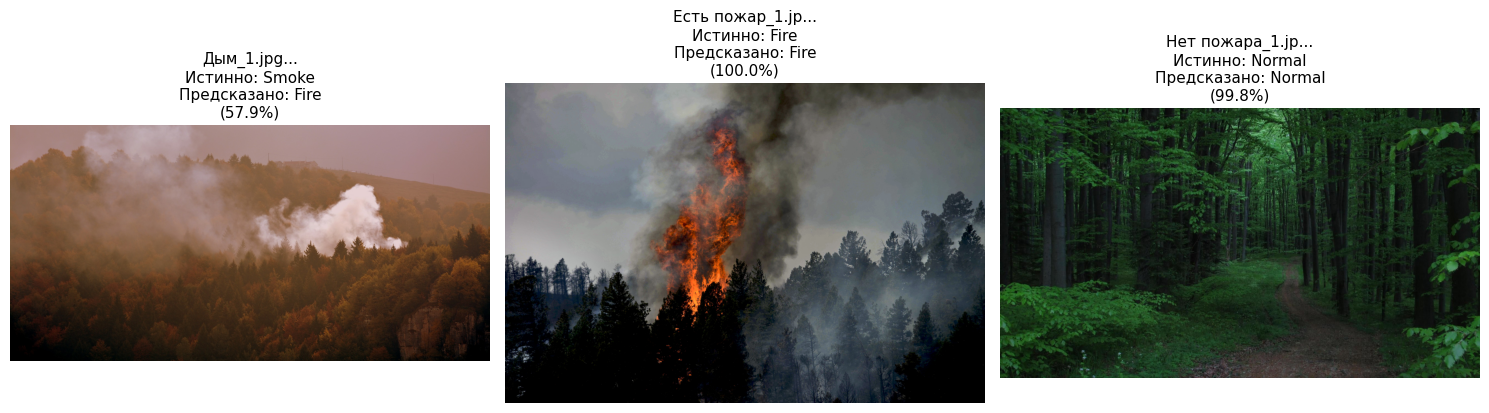


Метрики качества

Accuracy: 71.4%


Матрица ошибок



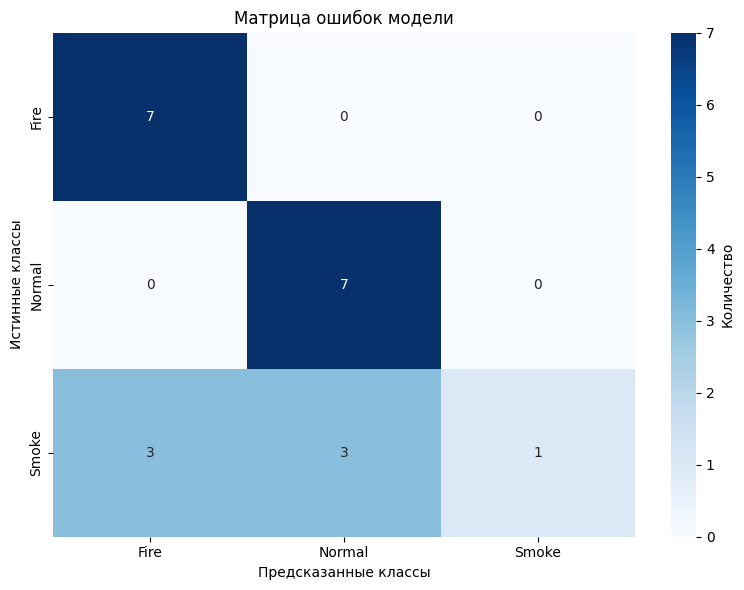


Метрики качества для каждого класса

+---------+-------------+----------+------------+---------------+
| Класс   | Precision   | Recall   | F1-Score   |   Кол-во фото |
+=========+=============+==========+============+===============+
| Fire    | 70.0%       | 100.0%   | 82.4%      |             7 |
+---------+-------------+----------+------------+---------------+
| Normal  | 70.0%       | 100.0%   | 82.4%      |             7 |
+---------+-------------+----------+------------+---------------+
| Smoke   | 100.0%      | 14.3%    | 25.0%      |             7 |
+---------+-------------+----------+------------+---------------+


In [60]:
from transformers import AutoImageProcessor, SiglipForImageClassification
from PIL import Image
import torch
import os
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

# 1. Загрузим модель для обнаружения пожаров в лесу
model = SiglipForImageClassification.from_pretrained("prithivMLmods/Forest-Fire-Detection")
processor = AutoImageProcessor.from_pretrained("prithivMLmods/Forest-Fire-Detection")

# Классы модели:
model_labels = {"0": "Fire", "1": "Normal", "2": "Smoke"}
class_labels = ["Fire", "Normal", "Smoke"]

print("Модель загружена\n")

# 2. Создадим словарь, в котором каждому файлу из нашей папки с изображениями будет соответствовать истинное значение класса:
# Нормальная лесная сцена (Normal)/Пожар (Fire)/Дым (Smoke)
true_labels = {
    "Дым_1.jpg": "Smoke",
    "Дым_2.jpg": "Smoke",
    "Дым_3.jpg": "Smoke", 
    "Дым_4.jpg": "Smoke",
    "Дым_5.jpg": "Smoke",
    "Дым_6.jpg": "Smoke",
    "Дым_7.jpg": "Smoke",
    "Есть пожар_1.jpg": "Fire",
    "Есть пожар_2.jpg": "Fire",
    "Есть пожар_3.jpg": "Fire",
    "Есть пожар_4.jpg": "Fire",
    "Есть пожар_5.jpg": "Fire",
    "Нет пожара_1.jpg": "Normal",
    "Нет пожара_2.jpg": "Normal",
    "Нет пожара_3.jpg": "Normal",
    "Нет пожара_4.jpg": "Normal",
    "Нет пожара_5.jpg": "Normal",
    "Нет пожара_7.jpg": "Normal",
    "Пожар_6.jpg": "Fire",
    "Пожар_7.jpg": "Fire",
    "Туман.jpg": "Normal"
}

#3. Получим предсказанные моделью классы для наших изображений:

folder_path = "C:/Users/U_M1P8G/Desktop/IDE/Проектная практика/Photo"
supported_ext = {'.jpg'}

# Файлы из словаря:
image_files = [f for f in true_labels.keys() 
               if os.path.exists(os.path.join(folder_path, f))]

print(f"Найдено изображений: {len(image_files)}")

results = []
y_true = []  # Истинные метки
y_pred = []  # Предсказанные метки
images_for_viz = []

#Запустим цикл для получения предсказания класса:

for filename in image_files:
    try:
        filepath = os.path.join(folder_path, filename)
        image = Image.open(filepath).convert("RGB")
        
        # Классификация моделью
        inputs = processor(images=image, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)[0]
        
        # Предсказанный класс
        class_idx = torch.argmax(probs).item()
        pred_class = model_labels.get(str(class_idx), f"Class_{class_idx}")
        confidence = probs[class_idx].item() * 100
        
        # Истинный класс
        true_class = true_labels.get(filename)
        
        if true_class is None:
            print(f"Файл {filename} есть в папке, но нет в словаре true_labels_dict")
            is_correct = "?"
        else:
            # Сравниваем истинный и предсказанный классы
            if true_class == pred_class:
                is_correct = "Да"
            else:
                is_correct = "Нет"
            
            # Сохраняем для метрик
            y_true.append(true_class)
            y_pred.append(pred_class)
        
        # Сохраняем результат
        results.append([
            filename,
            true_class if true_class else "Нет в словаре",
            pred_class,
            f"{confidence:.1f}%",
            is_correct
        ])
        
        # Для визуализации (выбираем разные классы)
        if len(images_for_viz) < 3 and true_class is not None:
            # Добавляем, только если класс еще не представлен
            existing_classes = [img[1] for img in images_for_viz]
            if true_class not in existing_classes:
                images_for_viz.append((image, true_class, pred_class, filename, confidence))
        
        
    except FileNotFoundError:
        print(f"Файл {filename} есть в словаре, но не найден в папке")
        results.append([filename, true_labels.get(filename), "Файл не найден", "0%", "Ошибка"])
    except Exception as e:
        print(f"Ошибка с {filename}: {e}")
        results.append([filename, true_labels.get(filename), "Ошибка обработки", "0%", "Ошибка"])

# 4. Выведем таблицу результатов классификации

print("\nТаблица результатов классификации\n")

table_headers = ["Файл", "Истинный класс", "Предсказанный класс", "Уверенность", "Правильно?"]
print(tabulate(results, headers=table_headers, tablefmt="grid"))

# Подсчет правильных ответов
correct_count = sum(1 for r in results if r[4] == "Да")
total_labeled = sum(1 for r in results if r[4] in ["Да", "Нет"])
if total_labeled > 0:
    accuracy = correct_count / total_labeled * 100
    print(f"\nСтатистика: {correct_count} правильных из {total_labeled} ({accuracy:.1f}%)")

# 5. Визуализируем 3 изображения

if images_for_viz:
    
    print("\nВизуализация изображений\n")
        
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
    colors = {"Fire": "red", "Smoke": "orange", "Normal": "green"}
    
    for idx, (img, true_class, pred_class, filename, confidence) in enumerate(images_for_viz[:3]):
        ax = axes[idx]
        ax.imshow(img)
        
        title = f"{filename[:15]}...\nИстинно: {true_class}\nПредсказано: {pred_class}\n({confidence:.1f}%)"
        ax.set_title(title, fontsize=11)
        ax.axis('off')
        
    
    plt.tight_layout()
    plt.show()
   

# 6. Оценим качество модели
print("\nМетрики качества\n")
    
# Преобразуем метки в числовой формат
label_to_num = {"Fire": 0, "Normal": 1, "Smoke": 2}
y_true_num = [label_to_num[label] for label in y_true]
y_pred_num = [label_to_num[label] for label in y_pred]
    
# 6.1. Рассчитаем Accurcy:
accuracy = accuracy_score(y_true_num, y_pred_num) * 100
print(f"Accuracy: {accuracy:.1f}%\n")
    
# 6.2. Выведем матрицу ошибок
cm = confusion_matrix(y_true_num, y_pred_num)
    
print("\nМатрица ошибок\n")

# Визуализация матрицы
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels,
                cbar_kws={'label': 'Количество'})
plt.title('Матрица ошибок модели')
plt.ylabel('Истинные классы')
plt.xlabel('Предсказанные классы')
plt.tight_layout()
plt.show()

# 6.3. Рассчитаем метрики качества для каждого класса

print("\nМетрики качества для каждого класса\n")

# Precision для каждого класса
precision_per_class = precision_score(y_true_num, y_pred_num, average=None)
recall_per_class = recall_score(y_true_num, y_pred_num, average=None)
f1_per_class = f1_score(y_true_num, y_pred_num, average=None)

# Создаем таблицу метрик
metrics_table = []
for i, class_name in enumerate(class_labels):
    metrics_table.append([
        class_name,
        f"{precision_per_class[i]*100:.1f}%",
        f"{recall_per_class[i]*100:.1f}%", 
        f"{f1_per_class[i]*100:.1f}%",
        np.sum(cm[i, :])  # Количество фото этого класса
    ])

print(tabulate(metrics_table, 
              headers=["Класс", "Precision", "Recall", "F1-Score", "Кол-во фото"],
              tablefmt="grid"))


    

### Выводы:
1. Модель хорошо определяет классы "Fire" и "Normal" (ни разу не приняла истинный пожар или нормальную сцену на что-то иное), но "путается" с дымом ("Smoke"). Причем определение класса "Smoke" как "Fire"не так критично, как определение фото с дымом за нормальную сцену.
2. Модель в текущем виде можно использовать, но с ограничениями: если модель определяет класс как "Normal", но уверена в этом менее чем на 85-90%, требуется проверка вручную
3. Желательно дообучить модель на более разнообразных фото с дымом для лучшего определения этого класса

#### Дополнительный анализ
Поскольку для практических целей важно не столько отличить пожар от дыма, сколько выявить тревожные сигналы, связанные с пожаром (признаком которого может быть дым), посмотрим на определение моделью двух классов - "тревога" (Fire/Smoke) и "норма".

Найдено изображений: 21

Таблица результатов классификации (бинарная)

+------------------+------------------+-----------------------+------------------+---------------+--------------+
| Файл             | Истинный класс   | Предсказанный класс   | Исходный класс   | Уверенность   | Правильно?   |
+==================+==================+=======================+==================+===============+==============+
| Дым_1.jpg        | Тревога          | Тревога               | Fire             | 75.3%         | Да           |
+------------------+------------------+-----------------------+------------------+---------------+--------------+
| Дым_2.jpg        | Тревога          | Норма                 | Normal           | 52.1%         | Нет          |
+------------------+------------------+-----------------------+------------------+---------------+--------------+
| Дым_3.jpg        | Тревога          | Тревога               | Fire             | 91.3%         | Да           |
+----------------

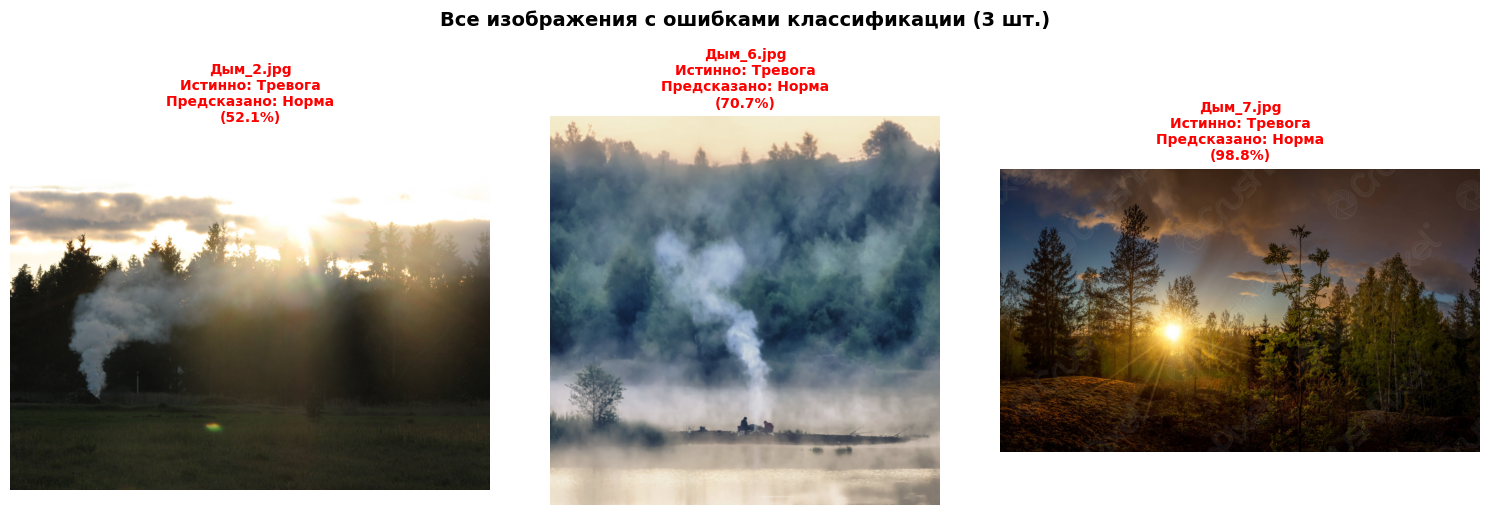

Метрики качества


 Для класса 'Тревога':
+----------------------+------------+--------------------------------------------+
| Метрика              | Значение   | Интерпретация                              |
+======================+============+============================================+
| Precision (точность) | 100.0%     | Из предсказанных 'Тревога' - сколько верны |
+----------------------+------------+--------------------------------------------+
| Recall (полнота)     | 78.6%      | Из реальных 'Тревога' - сколько обнаружено |
+----------------------+------------+--------------------------------------------+
| F1-Score             | 88.0%      |                                            |
+----------------------+------------+--------------------------------------------+

Для класса 'Норма':
+---------------------+------------+----------------------------------------------------+
| Метрика             | Значение   | Интерпретация                                      |
+=========

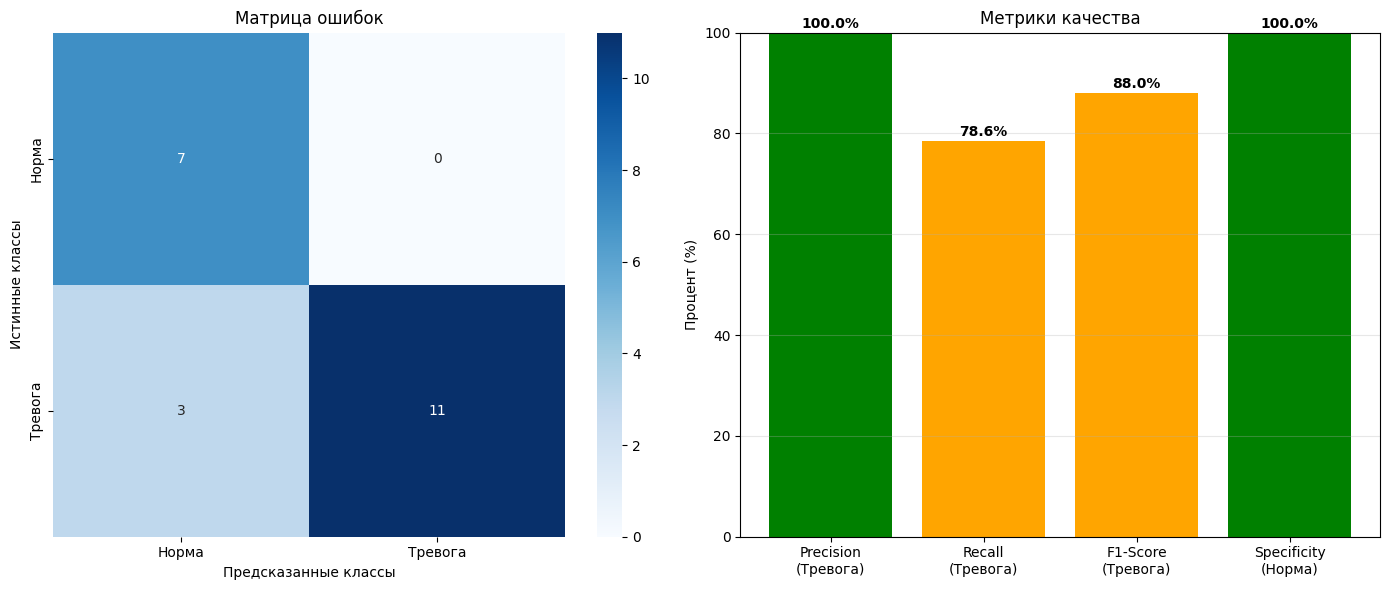

In [61]:
# 1. Создадим словарь с истинными значениями в бинарной классификации
true_labels_bin = {
    "Дым_1.jpg": "Тревога",
    "Дым_2.jpg": "Тревога",
    "Дым_3.jpg": "Тревога", 
    "Дым_4.jpg": "Тревога",
    "Дым_5.jpg": "Тревога",
    "Дым_6.jpg": "Тревога",
    "Дым_7.jpg": "Тревога",
    "Есть пожар_1.jpg": "Тревога",
    "Есть пожар_2.jpg": "Тревога",
    "Есть пожар_3.jpg": "Тревога",
    "Есть пожар_4.jpg": "Тревога",
    "Есть пожар_5.jpg": "Тревога",
    "Пожар_6.jpg": "Тревога",
    "Пожар_7.jpg": "Тревога",
    "Нет пожара_1.jpg": "Норма",
    "Нет пожара_2.jpg": "Норма",
    "Нет пожара_3.jpg": "Норма",
    "Нет пожара_4.jpg": "Норма",
    "Нет пожара_5.jpg": "Норма",
    "Нет пожара_7.jpg": "Норма",
    "Туман.jpg": "Норма"
}

# 2. Создадим функцию преобразования классов в бинарные значения
def convert_to_binary(pred_class, probs):
    if pred_class in ["Fire", "Smoke"]:
        prob_fire = probs[0].item() if len(probs) > 0 else 0
        prob_smoke = probs[2].item() if len(probs) > 2 else 0
        confidence = (prob_fire + prob_smoke) * 100
        return "Тревога", confidence, pred_class
    else:
        prob_normal = probs[1].item() if len(probs) > 1 else 0
        confidence = prob_normal * 100
        return "Норма", confidence, pred_class

# 3. Получим значения классов от модели

results_bin = []
all_errors = []  # здесь будем хранить изображения с ошибками предсказания

print(f"Найдено изображений: {len(image_files)}")

for filename in image_files:
    try:
        filepath = os.path.join(folder_path, filename)
        image = Image.open(filepath).convert("RGB")
        
        inputs = processor(images=image, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)[0]
        
        class_idx = torch.argmax(probs).item()
        pred_original = model_labels.get(str(class_idx), f"Class_{class_idx}")
        
        pred_binary, confidence, original_class = convert_to_binary(pred_original, probs)
        true_class = true_labels_bin.get(filename)
        
        if true_class is not None:
            if true_class == pred_binary:
                is_correct = "Да"
            else:
                is_correct = "Нет"
                # Сохраняем все ошибки
                all_errors.append((image.copy(), true_class, pred_binary, filename, confidence, original_class))
        
        results_bin.append([
            filename,
            true_class if true_class else "Нет в словаре",
            pred_binary,
            original_class,
            f"{confidence:.1f}%",
            is_correct if 'is_correct' in locals() else "?"
        ])
        
    except Exception as e:
        print(f"Ошибка с {filename}: {e}")

# 4. Выведем таблицу результатов
print("\nТаблица результатов классификации (бинарная)\n")

table_headers = ["Файл", "Истинный класс", "Предсказанный класс", "Исходный класс", "Уверенность", "Правильно?"]
print(tabulate(results_bin, headers=table_headers, tablefmt="grid"))

# 5. Визуализируем изображения с ошибками

if len(all_errors) > 0:
    # Определяем размер сетки
    num_errors = len(all_errors)
    
    fig, axes = plt.subplots(1, num_errors, figsize=(5*num_errors, 5))
    
    colors = {"Тревога": "red", "Норма": "green"}
    
    for idx, (img, true_class, pred_class, filename, confidence, orig_class) in enumerate(all_errors):
        ax = axes[idx]
        ax.imshow(img)
        
        title = (f"{filename}\n"
                f"Истинно: {true_class}\n"
                f"Предсказано: {pred_class}\n"
                f"({confidence:.1f}%)")
        
        ax.set_title(title, fontsize=10, fontweight='bold', color='red')
        ax.axis('off')
        
    
    plt.suptitle(f'Все изображения с ошибками классификации ({num_errors} шт.)', 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
# 6. Построим матрицу ошибок и рассчитаем метрики качества

# Преобразуем метки в числовой формат для расчетов
y_true = []
y_pred = []

for result in results_bin:
    true_class = result[1]
    pred_class = result[2]
    is_correct = result[5]
    
    if is_correct in ["Да", "Нет"]:  # Только размеченные данные
        y_true.append(true_class)
        y_pred.append(pred_class)
    
# Преобразуем в числовой формат (Тревога=1, Норма=0)
y_true_num = [1 if label == "Тревога" else 0 for label in y_true]
y_pred_num = [1 if label == "Тревога" else 0 for label in y_pred]
    
# 6.1. Матрица ошибок
cm = confusion_matrix(y_true_num, y_pred_num)    
tn, fp, fn, tp = cm.ravel()

# 6.2. Метрики качества
# Т.к. классы несбалансированы, не используем accuracy. Возьмем для оценки Precision, Recall, F1-Score
print("Метрики качества\n")
# Precision, Recall, F1 для класса "Тревога"
precision_tревога = tp / (tp + fp) * 100 if (tp + fp) > 0 else 0
recall_tревога = tp / (tp + fn) * 100 if (tp + fn) > 0 else 0
f1_tревога = 2 * precision_tревога * recall_tревога / (precision_tревога + recall_tревога) if (precision_tревога + recall_tревога) > 0 else 0
    
# Specificity для класса "Норма"
specificity = tn / (tn + fp) * 100 if (tn + fp) > 0 else 0
   
print("\n Для класса 'Тревога':")
metrics_table_1 = [
    ["Precision (точность)", f"{precision_tревога:.1f}%", 
     "Из предсказанных 'Тревога' - сколько верны\n"],
    ["Recall (полнота)", f"{recall_tревога:.1f}%", 
     "Из реальных 'Тревога' - сколько обнаружено\n"],
    ["F1-Score", f"{f1_tревога:.1f}%"]
    ]
print(tabulate(metrics_table_1, headers=["Метрика", "Значение", "Интерпретация"], tablefmt="grid"))
    
print("\nДля класса 'Норма':")
metrics_table_0 = [
    ["Specificity", f"{specificity:.1f}%", 
     "Из реальных 'Норма' - сколько правильно определено\n"],
    ["False Positive Rate", f"{(100-specificity):.1f}%", 
     "Процент ложных тревог"]
    ]
print(tabulate(metrics_table_0, headers=["Метрика", "Значение", "Интерпретация"], tablefmt="grid"))

# 7. Визуализируем матрицу ошибок и метрики качества

# Создаем фигуру с двумя графиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 7.1. Матрица ошибок
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Норма', 'Тревога'], 
            yticklabels=['Норма', 'Тревога'],
            ax=ax1)
ax1.set_title('Матрица ошибок')
ax1.set_ylabel('Истинные классы')
ax1.set_xlabel('Предсказанные классы')

# 7.2. График метрик
metrics_names = ['Precision\n(Тревога)', 'Recall\n(Тревога)', 'F1-Score\n(Тревога)', 'Specificity\n(Норма)']
metrics_values = [precision_tревога, recall_tревога, f1_tревога, specificity]

# Цвета: зеленый > 90%, оранжевый 60-90%, красный < 60%
colors = []
for value in metrics_values:
    if value > 90:
        colors.append('green')
    elif value > 60:
        colors.append('orange')
    else:
        colors.append('red')

bars = ax2.bar(metrics_names, metrics_values, color=colors)
ax2.set_title('Метрики качества')
ax2.set_ylabel('Процент (%)')
ax2.set_ylim(0, 100)
ax2.grid(axis='y', alpha=0.3)

# Добавляем значения на столбцы
for bar, value in zip(bars, metrics_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{value:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

    


### Выводы:
1. В такой вариации использования качество модели выглядит лучше: модель ошиблась в 3 случаях из 21 (при 3 классах - в 6 случаях из 21).
Однако метрика recall показывает необходимость улучшения качества модели - пропущено 3 тревоги (из реальных "тревога" всего 21,4% определены как "норма") 
2. Посмотрим детальнее на фото, которые модель ошибочно определила как "норма". Все эти фото имеют истинную метку "тревога" и Smoke" при 3 классах:
- фото "Дым_2": уверенность модели в том, что это норма, всего 52,1%. Если мы снизим порог уверенности до 90%, то это фото пойдет на ручную проверку и тревога не будет пропущена
- фото "Дым_6": уверенность модели в том, что это норма также менее 90%, это фото отправилось бы на ручную проверку. Несмотря на то, что на фото дым от контролируемого людьми костра, и пожара в строгом смысле нет, местность, представленная на фото, требует контроля. Костер может стать источником пожара.
- фото "Дым_7": уверенность модели в "норме" высокая - 98,8%. Т.е. даже со снижением порога уверенности тревога была бы пропущена. Дым на фото есть, но он едва различим - возможно, именно из-за этого модель его спутала с туманом/облаками. Такие технически обусловленные ошибки могут быть. Выход - дообучение модели на фото в реальных условиях съемки - с дымом при наличии облаков/тумана, а также с дымом, который не так явно видно на фото.

Таким образом:
1. Для текущего использования рекомендуется двухуровневая система: автоматическое принятие решений только при уверенности более 90%, остальные случаи — ручная проверка оператором, особенно в пожароопасные периоды
2. В дальнейшем рекомендовано дообучение модели для лучшего распознавания дыма с ипользованием фото:
- дыма в сложных погодных условиях (туман, например)
- дыма, который слабо виден
- которые попали на ручную проверку оператору (что позволит усовершенствовать датасет для последующего обучения модели)